In [1]:
# Reference : https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers
!curl https://raw.githubusercontent.com/wallik3/bank-churn-prediction/main/Bank%20Customer%20Churn%20Prediction.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  548k  100  548k    0     0  1207k      0 --:--:-- --:--:-- --:--:-- 1208k


In [2]:
# Install and update packages
# !pip install -U scikit-learn # Do it, otherwise, TargetEncoder cannot be imported
# !pip install -U imblearn
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


## Our Goal
- To keep the customer continue using our service as long as possible. for better revenue



In [3]:
import pandas as pd
df = pd.read_csv("data.csv")
print(f"{len(df) = }")
df.sample(5)

len(df) = 10000


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
3505,15742834,640,France,Male,45,1,0.00,1,1,1,10908.33,0
2099,15593295,548,France,Male,57,6,76165.65,1,1,1,133537.53,0
3051,15619087,762,France,Male,53,1,102520.37,1,1,1,170195.40,0
8538,15648030,731,Spain,Female,33,5,137388.01,2,1,0,165000.68,0
1178,15782454,552,France,Male,49,4,0.00,1,1,1,190296.76,1


## Data Exploration
- Discuss on the status of this dataset

In [4]:
# No null, this dataset is ready to use
df[df.isnull().any(axis=1)]

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn


In [5]:
# Churn Rate
churn_rate = df["churn"].value_counts()[1] / len(df)
print(f"{churn_rate = }")

churn_rate = 0.2037


If this dataset is sampled with no bias, then the churn rate is 0.2037
- This is an imbalanced dataset, due to imbalance proportional label

In [6]:
df.sample(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
2369,15708212,648,Spain,Female,54,7,118241.02,1,1,0,172586.89,1
6899,15700263,569,France,Male,66,2,0.00,1,1,0,130784.20,1
4953,15684516,629,Spain,Male,34,1,121151.05,1,0,0,119357.93,0
9915,15813140,543,Spain,Male,41,5,0.00,2,0,1,143980.29,0
7857,15621457,850,France,Male,27,6,96654.72,2,0,0,152740.16,0


Want the plot to look good, and also suit with plotly format
(Category variable must be str, otherwise be treated as continuous variable)

In [7]:
# Design specifically for plotting which make it fit with plotly format
plot_df = df.copy(deep=True)

plot_df["churn"] = plot_df["churn"].map({0:"No", 1:"Yes"})
plot_df["active_member"] = plot_df["active_member"].map({0:"No", 1:"Yes"})
plot_df["credit_card"] = plot_df["credit_card"].map({0:"No", 1:"Yes"})
plot_df["products_number"] = plot_df["products_number"].astype(str)

plot_df = plot_df.rename(columns={
                "customer_id": "Customer Id",
                "credit_score": "Credit Score",
                "country": "Country",
                "gender": "Gender",
                "age": "Age",
                "tenure": "Tenure",
                "balance" : "Balance",
                "products_number" : "Products Number",
                "credit_card": "Credit Card",
                "active_member": "Active Member",
                "estimated_salary" : "Estimated Salary",
                "churn" : "Churn"
                })

In [8]:
plot_df

,Customer Id,Credit Score,Country,Gender,Age,Tenure,Balance,Products Number,Credit Card,Active Member,Estimated Salary,Churn
0,15634602,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,Yes
1,15647311,608,Spain,Female,41,1,83807.86,1,No,Yes,112542.58,No
2,15619304,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,Yes
3,15701354,699,France,Female,39,1,0.00,2,No,No,93826.63,No
4,15737888,850,Spain,Female,43,2,125510.82,1,Yes,Yes,79084.10,No
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,Yes,No,96270.64,No
9996,15569892,516,France,Male,35,10,57369.61,1,Yes,Yes,101699.77,No
9997,15584532,709,France,Female,36,7,0.00,1,No,Yes,42085.58,Yes
9998,15682355,772,Germany,Male,42,3,75075.31,2,Yes,No,92888.52,Yes


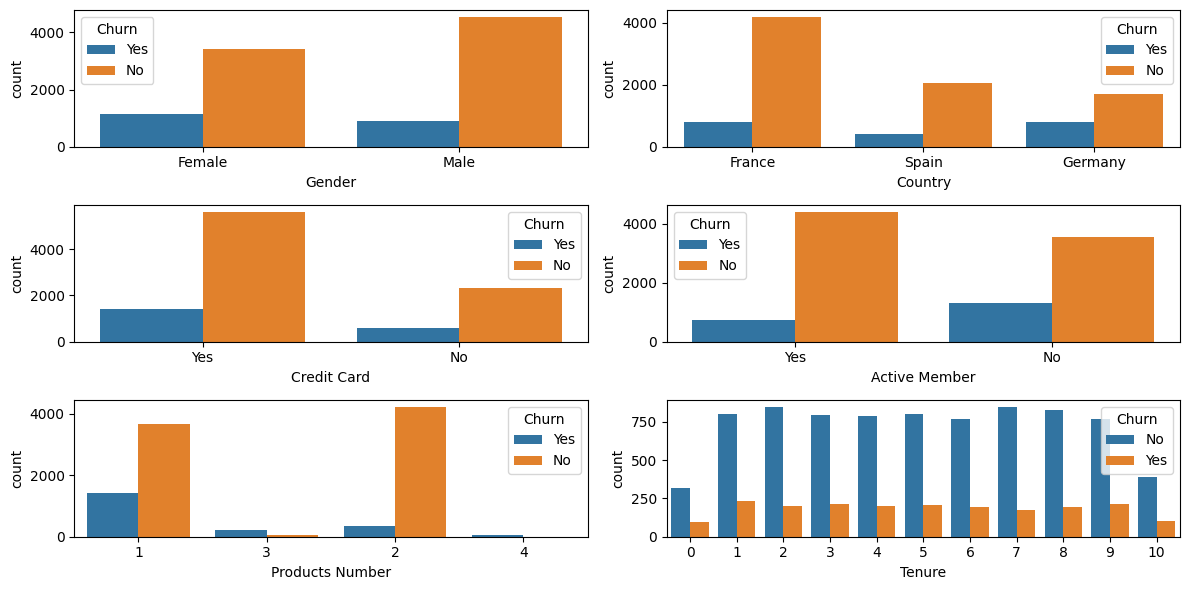

In [9]:
# @markdown
# @markdown Let's inspect seperated by each feature
# @markdown - The customer who have more than 2 products is more likely to churn (Is this often mean the product that they got is not popular, and they use them, make them strongly dissatisfied ?)
# @markdown - For example, if this bank have 4 products, A, B, C, D. Most of the people must product A first as a signature product of this bank. latter product is B (Which may be a very great one). Until the get product C or D, the customer feels bad. Not enough data, we better need the list of product the user is using
# @markdown - The customer who have 1 product is more likely to churn
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(12, 6))
sns.countplot(x='Gender', hue = 'Churn',data = plot_df, ax=ax[0][0])
sns.countplot(x='Country', hue = 'Churn',data = plot_df, ax=ax[0][1])
sns.countplot(x='Credit Card', hue = 'Churn',data = plot_df, ax=ax[1][0])
sns.countplot(x='Active Member', hue = 'Churn',data = plot_df, ax=ax[1][1])
sns.countplot(x='Products Number', hue = 'Churn',data = plot_df, ax=ax[2][0])
sns.countplot(x='Tenure', hue = 'Churn',data = plot_df, ax=ax[2][1])


plt.tight_layout()
plt.show()

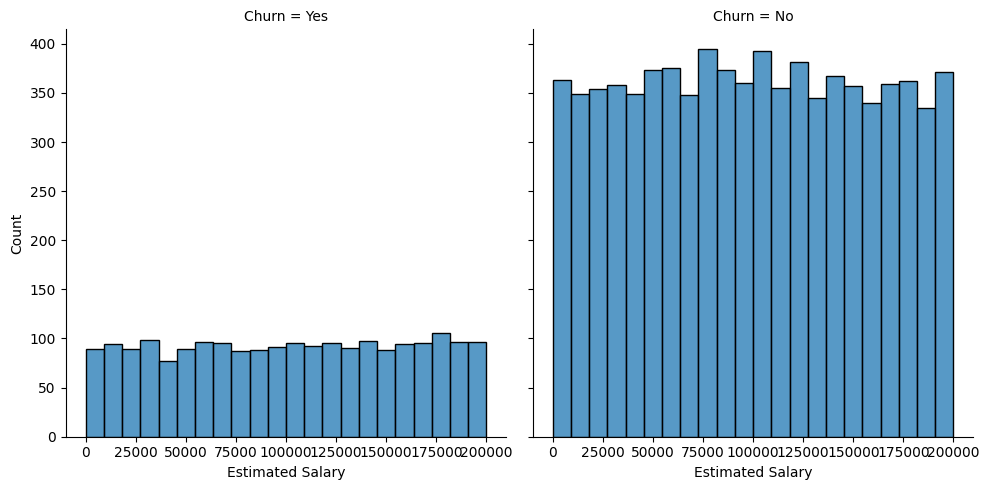

In [10]:
# @markdown - Regardless of zero balance customer, The distribution of Balances is likely to be uniform distribution.
# @markdown Just a note, we will later confirm it using Test of Uniformity
# @markdown - If normal, then we can wisely select the appropriate preprocessing technique (say Min-max scaler)

# g = sns.FacetGrid(plot_df, col="Churn")
# g.map(sns.histplot, "Churn")
sns.displot(data=plot_df, x='Estimated Salary', col="Churn", col_wrap=2)

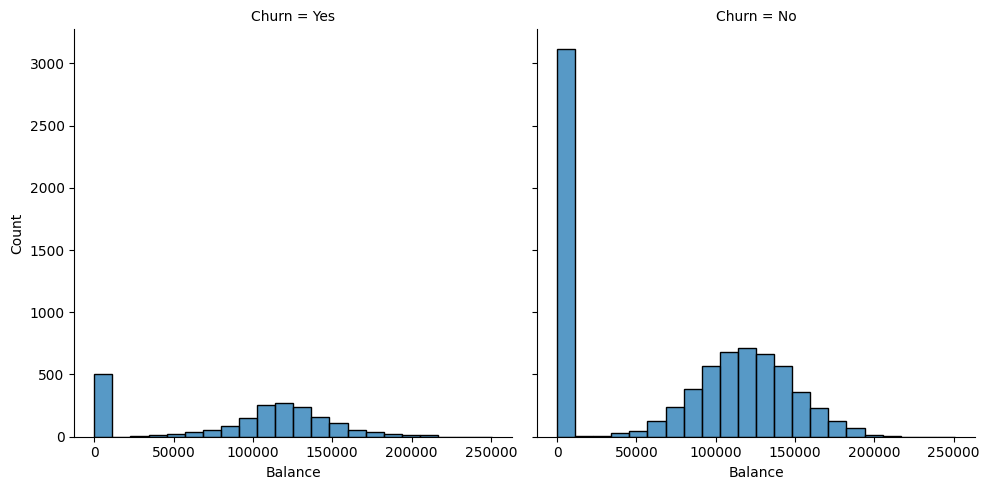

In [11]:
# @markdown - Regardless of zero balance customer, The distribution of Balances is likely to be normally distributed with mean around 120k.
# @markdown Just a note, we will later confirm it using Test of Normality (Q-Q Plot)
# @markdown - If normal, then we can wisely select the appropriate preprocessing technique (say StandardScaler w/ ignore zero balanced)

sns.displot(data=plot_df, x='Balance', col="Churn", col_wrap=2)

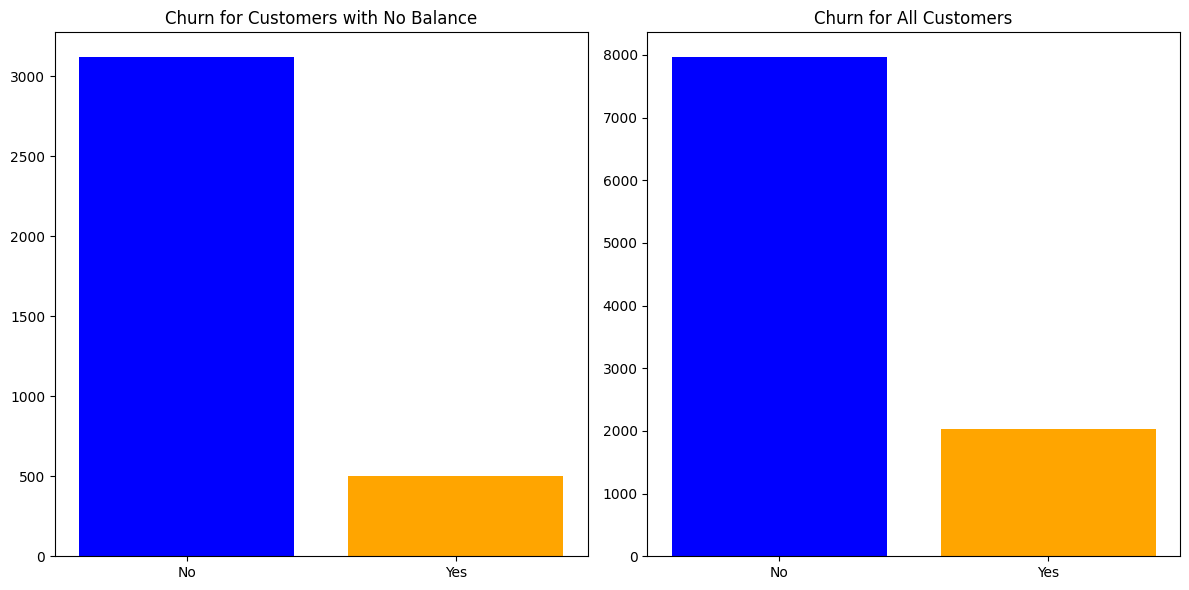

Chance of the customer with no balance being churn 0.05
Chance of the customer being churn 0.2037


In [12]:
# @markdown Just Curious on no balance
# @markdown - Now we found out that the proportion of them are different, the person who with no balance is less likely to have churn
# @markdown - p(churn|balance=0) = 0.05, while p(churn) = 0.2, this is 4 times far different
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for customers with no balance
no_balance_churn_df = plot_df.query('Balance == 0')
no_balance_churn_count = no_balance_churn_df["Churn"].value_counts()
axs[0].bar(no_balance_churn_count.index, no_balance_churn_count.values,color=['blue', 'orange'])
axs[0].set_title('Churn for Customers with No Balance')

# Plot for all customers
churn_count = plot_df["Churn"].value_counts()
axs[1].bar(churn_count.index, churn_count.values,color=['blue', 'orange'])
axs[1].set_title('Churn for All Customers')

plt.tight_layout()
plt.show()


print("Chance of the customer with no balance being churn",no_balance_churn_count[1]/(churn_count[0] + churn_count[1]))
print("Chance of the customer being churn",churn_count[1]/(churn_count[0] + churn_count[1]))

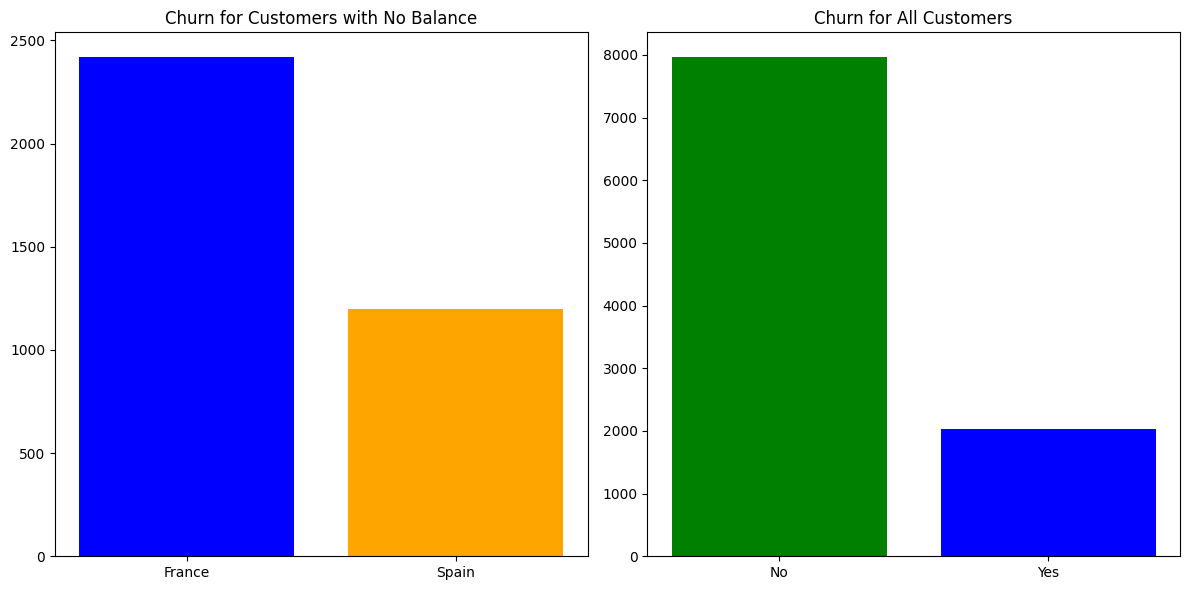

In [13]:
# @markdown - Hmm.. but who is most likely being churned if we knew they has balance = 0
# @markdown - It's funny that Non of customers in Germany have balaned less than 0
# @markdown - Maybe this bank is located at Germany, and being a main bank for Germany person. Just an assumption..

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for all customers
no_balance_churn_count = no_balance_churn_df["Country"].value_counts()
axs[0].bar(no_balance_churn_count.index, no_balance_churn_count.values,color=['blue', 'orange'])
axs[0].set_title('Churn for Customers with No Balance')

# Plot for all customers
axs[1].bar(churn_count.index, churn_count.values,color=['green','blue', 'orange'])
axs[1].set_title('Churn for All Customers')

plt.tight_layout()
plt.show()


In [14]:
france_no_balance = no_balance_churn_df.query('Country == "France"')

In [15]:
no_balance_churn_count

Country
France    2418
Spain     1199
Name: count, dtype: int64

In [16]:
# @markdown Let's inspect more on no-balance churn count
no_balance_churn_df["Country"]

0       France
3       France
6       France
11       Spain
12      France
         ...  
9989     Spain
9992     Spain
9994    France
9995    France
9997    France
Name: Country, Length: 3617, dtype: object

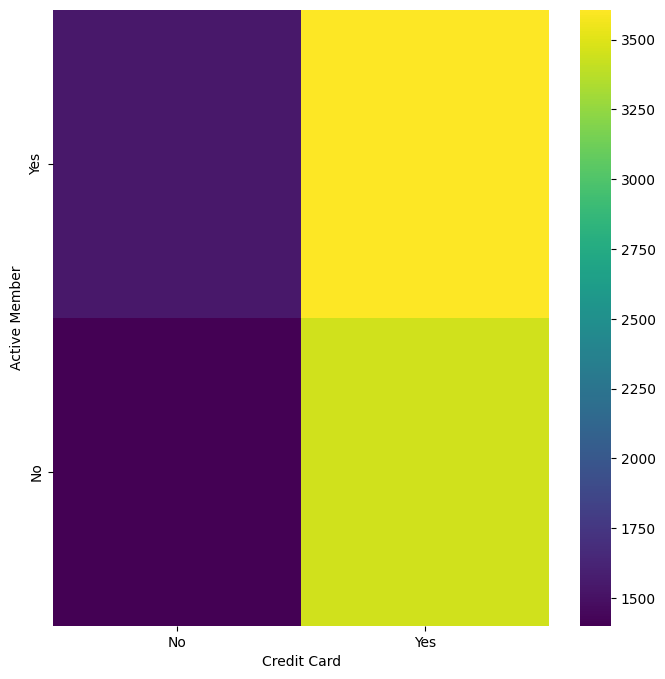

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Active Member'].value_counts()
    for x_label, grp in plot_df.groupby('Credit Card')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Credit Card')
_ = plt.ylabel('Active Member')

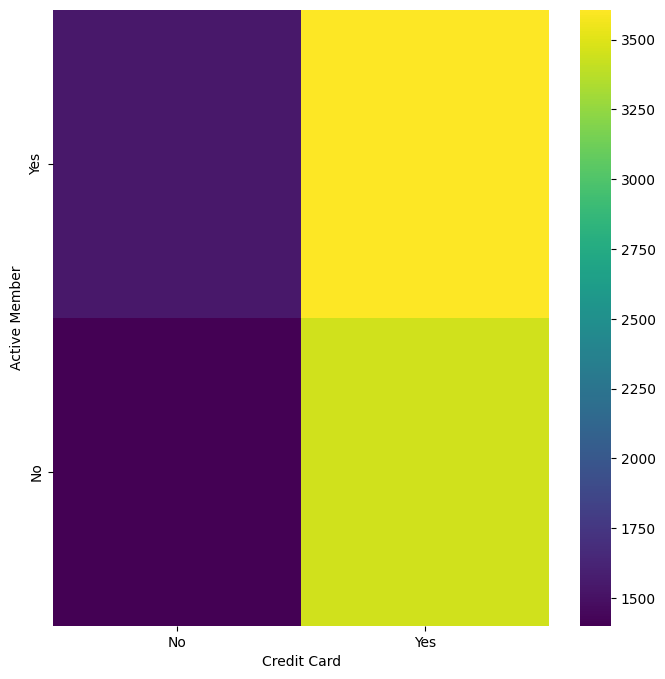

In [18]:
# @title Credit Card vs Active Member

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Active Member'].value_counts()
    for x_label, grp in plot_df.groupby('Credit Card')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Credit Card')
_ = plt.ylabel('Active Member')

In [19]:
plot_df

,Customer Id,Credit Score,Country,Gender,Age,Tenure,Balance,Products Number,Credit Card,Active Member,Estimated Salary,Churn
0,15634602,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,Yes
1,15647311,608,Spain,Female,41,1,83807.86,1,No,Yes,112542.58,No
2,15619304,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,Yes
3,15701354,699,France,Female,39,1,0.00,2,No,No,93826.63,No
4,15737888,850,Spain,Female,43,2,125510.82,1,Yes,Yes,79084.10,No
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,Yes,No,96270.64,No
9996,15569892,516,France,Male,35,10,57369.61,1,Yes,Yes,101699.77,No
9997,15584532,709,France,Female,36,7,0.00,1,No,Yes,42085.58,Yes
9998,15682355,772,Germany,Male,42,3,75075.31,2,Yes,No,92888.52,Yes


In [20]:
import plotly.express as px
# fig = px.parallel_coordinates(plot_df.sample(100), color="Churn",
#                 color_continuous_scale=px.colors.diverging.Tealrose,
#                 color_continuous_midpoint=2)
# fig.show()

In [21]:
plot_df["Churn_encode"] = plot_df["Churn"].map({"Yes" : 1, "No" : 0})
fig = px.line(plot_df, x="Customer Id", y="Churn_encode")
fig.show()

In [22]:
plot_df["Churn"].value_counts()

Churn
No     7963
Yes    2037
Name: count, dtype: int64

In [23]:
dfg=plot_df.groupby('Churn').count().reset_index()

In [24]:
dfg=plot_df.groupby('Churn').count().reset_index()

fig = px.bar(dfg, x="Churn", y="Customer Id", color="Churn", title="Churn by Count")
fig.show()

## Univariate Analysis
- Explore individual features corresponding to Churn Status

Using the Customer ID as a feature might be useful if it is based on the registration date. This way, we can see if there is a pattern of churn among customers who registered earlier or later. However, this feature would not help us predict the churn of new customers who have not registered yet

(Action : Ignore this column as feature)

In [25]:
import plotly.express as px
fig = px.scatter(plot_df, x="Customer Id", y="Churn", color="Churn", title="Customer ID by Churn")
fig.show()

Inspecting that if the credit score of customer is lower than 405, then they are 100% churn from the sample.

In [26]:
fig = px.box(plot_df, x="Churn", y="Credit Score", color="Churn", title="Credit Score by Churn")
fig.show()

In [27]:
fig = px.bar(plot_df, x="Country", y="Churn", color="Churn", title="Country by Churn", barmode="group")
fig.show()

In [28]:
fig = px.pie(plot_df, names="Gender", color="Churn", title="Gender by Churn", hole=0.4)
# fig = px.pie(plot_df, names="Credit Card", color="Churn", title="Credit Card by Churn", hole=0.4)

fig.show()

In [29]:
fig = px.histogram(plot_df, x="Age", color="Churn", title="Age by Churn", nbins=10)
fig.show()

In [30]:
plot_df["Tenure"] = plot_df["Tenure"].astype(str)
fig = px.bar(plot_df.sample(1000), x="Tenure", y="Balance", color="Churn", title="Balance by Tenure and Churn")
fig.show()

In [31]:
fig = px.density_contour(plot_df, x="Balance", y="Churn", color="Churn", title="Balance by Churn")
fig.show()

In [32]:
fig = px.pie(plot_df, names="Credit Card", color="Churn", title="Credit Card by Churn", hole=0.4)
fig.show()

If the customer is likely an active member, the chance of churn

In [33]:
fig = px.treemap(df, path=["active_member", "churn"], title="Active Member by Churn")
fig.show()

In [34]:
fig = px.violin(df, x="churn", y="estimated_salary", color="churn", title="Estimated Salary by Churn")
fig.show()

## Modelling
- Creating the machine learning to learn the pattern of these to inference the chance of being churn
- The best model have the best score in validation set

![](https://miro.medium.com/max/1190/1*I0F-ALOL8J8f6V33CDKyrA.png)
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

### Train/Validation/Test set
- To make sure the model generalize the data well
- Since the dataset label is imbalanced, we have to split to make sure all sets have same distribution

In [35]:
from typing import List, Tuple, Sequence
from sklearn.model_selection import train_test_split

def df_to_xy(df, label:str):
  """
  Split the full dataframe into two dataframe; X and y
  """
  X = df.loc[:, ~df.columns.isin([label])]
  y = df[label]
  return X,y

def split_set(df:pd.DataFrame,
              label:str,
              seed:int=42,
              prop:Tuple[int]=(0.7,0.15,0.15))->Tuple[pd.DataFrame]:

  # Imbalancing splitting the dataset
  X,y = df_to_xy(df,label)

  # Pre-calculated the validation proportion
  train_prop, val_prop, test_prop = prop
  test_size = test_prop * len(df)
  train_size = len(df) - test_size
  train_val_prop = (test_size / train_size)

  X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                      test_size=test_prop,
                                                      random_state=seed,
                                                      stratify=y)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=train_val_prop,
                                                  random_state=seed,
                                                  stratify=y_train)

  # Concat into a single dataframe for all set
  train = pd.concat([X_train, y_train], axis=1)
  val = pd.concat([X_val, y_val], axis=1)
  test = pd.concat([X_test, y_test], axis=1)
  return (train,val,test)


In [36]:
# Drop customer_id due to its useless
df.drop(["customer_id"],axis=1,inplace=True)

label = "churn"
seed = 42
train,val,test = split_set(df.copy(), label, seed)

# Split for later used
X_train,y_train = df_to_xy(train,label)
X_val,y_val = df_to_xy(val,label)
X_test,y_test = df_to_xy(test,label)

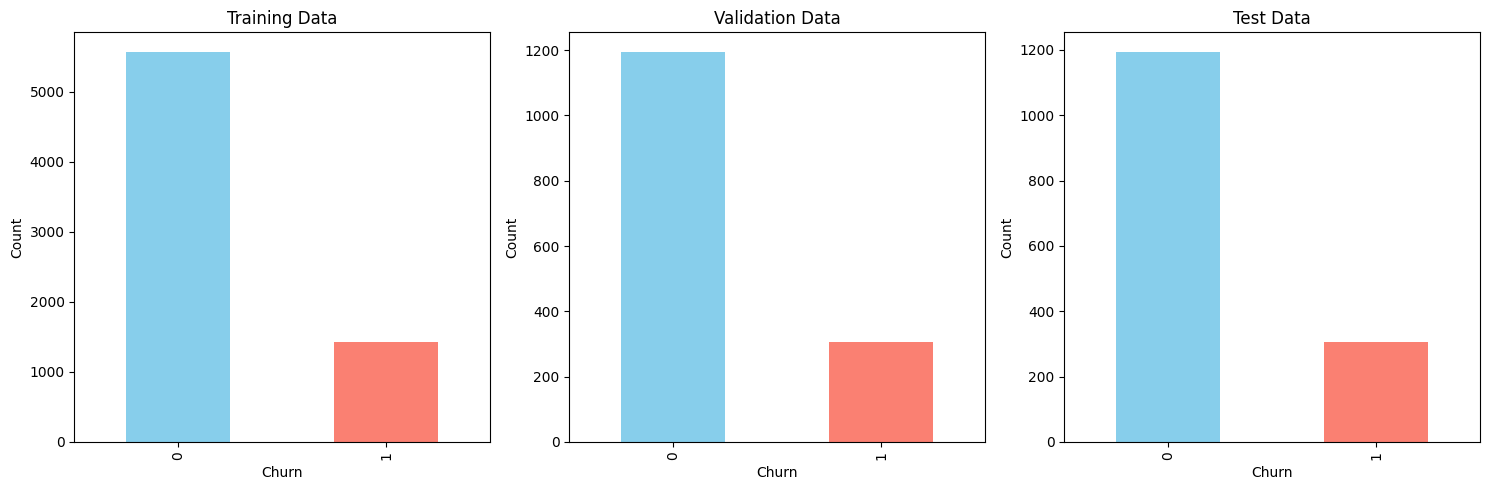

In [37]:
import matplotlib.pyplot as plt

# Assuming you have already loaded your data into train, val, and test DataFrames
# Replace 'churn' with the actual column name in your dataset

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for training data
train["churn"].value_counts().plot(kind="bar", ax=axes[0], color=["skyblue", "salmon"])
axes[0].set_title("Training Data")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Count")

# Plot for validation data
val["churn"].value_counts().plot(kind="bar", ax=axes[1], color=["skyblue", "salmon"])
axes[1].set_title("Validation Data")
axes[1].set_xlabel("Churn")
axes[1].set_ylabel("Count")

# Plot for test data
test["churn"].value_counts().plot(kind="bar", ax=axes[2], color=["skyblue", "salmon"])
axes[2].set_title("Test Data")
axes[2].set_xlabel("Churn")
axes[2].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

### Preprocessing
- Make the data usable when fitting
- What is the best data-preprocessing, we will make pipeline

In [38]:
# @title Preprocess Example {display-mode: "form"}
# @markdown This is a structure of how we make preprocess pipeline

def preprocess_example():
  # Ignore these code
  from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
  from sklearn.compose import ColumnTransformer
  from sklearn.pipeline import Pipeline


  # Make numeric transformer
  numeric_features = ["estimated_salary"]
  categorical_features = ["country", "gender"]  # Include both categorical features

  # Create transformers
  numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
  categorical_onehot_transformer = Pipeline(steps=[("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])
  categorical_ordinal_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])  # Add OrdinalEncoder

  # Combine transformers using ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numeric_transformer, numeric_features),
          ("cat_onehot", categorical_onehot_transformer, ["country"]),
          ("cat_ordinal", categorical_ordinal_transformer, ["gender"]),  # Apply OrdinalEncoder
      ],

      remainder="passthrough",).set_output(transform="pandas")   # Keep other columns unchanged
      # We are going to store all preprocessor here

  # The candidate are all stored here
  preprocessers = {
          "x1" : preprocessor
      }
  # Test to see the output of preprocesser
  # preprocessers["x1"].fit_transform(X_train)

You can also create a custom step in Sklearn Pipeline :
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

- We are going to create a preprocessing pipeline for each type of column data type (numeric, categoric)
- We are going to pick some of preprocess pipeline. We will give the initial pipeline name with prefix a, once found the best, we will modify using that columntransformer instead

In [39]:
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    KBinsDiscretizer,
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Tuple, Optional

# Let's add a new strategy to StandardScaler

class SelectiveStandardScaler(BaseEstimator, TransformerMixin):
    # This transformer returns dataframe instead of default ndarray
    def __init__(self,
                 standard_scaler,
                 ignore_value:Tuple[float],):

      self.standard_scaler = standard_scaler
      self.ignore_value = ignore_value

      self.transformer_for_interested = standard_scaler
      # self.transformer_for_ignore = lambda x : x if handle_ignore_value else self.transformer_for_interested
      print("PASSED")

    def _filter_data(self,X: pd.DataFrame):
      """
        X
      """
      if isinstance(X, pd.DataFrame):
        self.feature_names : List[str]
        self.feature_names = X.columns.values

        assert len(self.feature_names) == 1
        self.feature_name = self.feature_names[0]
        interested_X = X.query(f"{self.feature_name} != {self.ignore_value}")
        ignored_X = X.query(f"{self.feature_name} == {self.ignore_value}")

        return interested_X, ignored_X


    def fit(self, X, y=None):
      """
      Assume that X is pandas Dataframe containing a selected column
      """
      # Fit only on interested data
      interested_X, _ = self._filter_data(X)

      return self.transformer_for_interested.fit(interested_X)

    def transform(self, X):
      if isinstance(X, pd.DataFrame):
        # interested_X, ignored_X = self._filter_data(X)
        # print(f"{interested_X = }")
        interested_y = self.transformer_for_interested.transform(X)
        interested_y = pd.DataFrame(interested_y,columns=[self.feature_name])
        return interested_y
        # print(interested_y)

        # interested_y = pd.DataFrame(interested_y,columns=[self.feature_name])
        # # print(interested_y)

        # y = pd.concat([interested_y,ignored_X],axis=0)
        # return y






        # print(X[self.feature_name])
        # # transformed_X = X[self.feature_name].map(lambda x: self.transformer_for_ignore(x) if x == self.ignore_value else self.transformer_for_interested.transform(x))
        # transformed_X = X[self.feature_name].map(lambda x: x)

        # # transformed_X = X[column.values[0]].map(lambda x: self.transformer_for_ignore(x) if x == self.ignore_value else self.transformer_for_interested.transform(x))
        # return transformed_X


In [41]:
selective_standard_scaler = SelectiveStandardScaler(standard_scaler=StandardScaler(),
                                                    ignore_value=0)
selective_standard_scaler.fit(X_train[["balance"]])
selective_standard_scaler.transform(X_train[["balance"]])

PASSED


,balance
0,0.350855
1,-3.965102
2,-3.965102
3,-3.965102
4,0.914676
...,...
6995,-1.281304
6996,-1.920054
6997,-3.965102
6998,-0.821529


In [42]:
# Make numeric transformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

numeric_features = ["estimated_salary"]
categorical_features = ["country", "gender"]  # Include both categorical features

# Create transformers
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_onehot_transformer = Pipeline(steps=[("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])
categorical_ordinal_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])  # Add OrdinalEncoder

# Make preprocessor_a1
preprocessor_a1 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["estimated_salary"]),
        ("cat_nom", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["country"]),
        ("cat_ord", OrdinalEncoder(), ["gender"]),  # Apply OrdinalEncoder
    ],
    remainder="passthrough",)   # Keep other columns unchanged

# Make preprocessor_a2
preprocessor_a2 = ColumnTransformer(
    transformers=[
        ("num", KBinsDiscretizer(encode="onehot", strategy ="quantile"), ["estimated_salary"]),
        ("cat_nom", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["country"]),
        ("cat_ord", OrdinalEncoder(), ["gender"]),  # Apply OrdinalEncoder
    ],
    remainder="passthrough",)   # Keep other columns unchanged

# Make preprocessor_a3
preprocessor_a3 = ColumnTransformer(
    transformers=[
        ("num", KBinsDiscretizer(encode="onehot", strategy ="quantile"), ["estimated_salary"]),
        ("cat_nom", TargetEncoder(smoothing=10), ["country"]),
        ("cat_ord", OrdinalEncoder(), ["gender"]),  # Apply OrdinalEncoder
    ],
    remainder="passthrough",)   # Keep other columns unchanged


# Make preprocessor_a4
preprocessor_a4 = ColumnTransformer(
    transformers=[
        ("num", KBinsDiscretizer(encode="onehot", strategy ="quantile"), ["estimated_salary"]),
        ("cat_nom", TargetEncoder(smoothing =10), ["country"]),
        ("cat_ord", OrdinalEncoder(), ["gender"]),  # Apply OrdinalEncoder
    ],
    remainder="passthrough",)   # Keep other columns unchanged


# Make preprocessor_a5
preprocessor_a5 = ColumnTransformer(
    transformers=[
        ("num", SelectiveStandardScaler(standard_scaler=StandardScaler(),ignore_value=0),  ["estimated_salary"] ),
        ("cat_nom", TargetEncoder(smoothing =10), ["country"]),
        ("cat_ord", OrdinalEncoder(), ["gender"]),  # Apply OrdinalEncoder
    ],
    remainder="passthrough",)   # Keep other columns unchanged


# Make preprocessor_a6 (+ Uniformly Scaled using Min-Max scaler)
preprocessor_a6 = ColumnTransformer(
    transformers=[
        ("num_selective_standard", SelectiveStandardScaler(standard_scaler=StandardScaler(),ignore_value=0),  ["estimated_salary"] ),
        ("num_minmax",MinMaxScaler(),["balance"]),
        ("cat_nom", TargetEncoder(smoothing =10), ["country"]),
        ("cat_ord", OrdinalEncoder(), ["gender"]),  # Apply OrdinalEncoder
    ],
    remainder="passthrough",)   # Keep other columns unchanged

PASSED
PASSED


In [43]:
# Bundle all preprocessers
preprocessers = {
          "a1" : preprocessor_a1,
          "a2" : preprocessor_a2,
          "a3" : preprocessor_a3,
          "a4" : preprocessor_a4,
          "a5" : preprocessor_a5,
          "a6" : preprocessor_a6,
      }

In [44]:
preprocessers["a6"].fit_transform(X_train,y_train)

PASSED


array([[-1.39945431,  0.5451844 ,  0.32806324, ...,  1.        ,
         0.        ,  0.        ],
       [-0.5525995 ,  0.        ,  0.16543491, ...,  2.        ,
         1.        ,  0.        ],
       [-1.27381449,  0.        ,  0.16543491, ...,  2.        ,
         1.        ,  1.        ],
       ...,
       [ 1.65502433,  0.        ,  0.16543491, ...,  2.        ,
         1.        ,  1.        ],
       [ 0.37428387,  0.3970909 ,  0.32806324, ...,  2.        ,
         1.        ,  0.        ],
       [-1.72845622,  0.53314502,  0.16543491, ...,  2.        ,
         0.        ,  0.        ]])

In [45]:
preprocessers["a6"]

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_selective_standard',
                                 SelectiveStandardScaler(ignore_value=0,
                                                         standard_scaler=StandardScaler()),
                                 ['estimated_salary']),
                                ('num_minmax', MinMaxScaler(), ['balance']),
                                ('cat_nom', TargetEncoder(), ['country']),
                                ('cat_ord', OrdinalEncoder(), ['gender'])])

Just to recall, the final Pipeline may look like this

```
 clf = Pipeline(
     steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
 )
```



### Define the metric
- We are going to choose AUROC as the first metric, if the model did predict with a strong confidence, then it has high AUROC
- Fine tune for the best threshold with F1 score

In [46]:
# import the necessary modules
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

def evaluate(pred, truth, threshold=0.5):
  # convert the predicted probabilities to binary labels
  predicted = (pred >= threshold).astype(int)
  # compute the confusion matrix
  cm = confusion_matrix(truth, predicted)
  # compute the weighted F1 score
  f1 = f1_score(truth, predicted, average='weighted')
  # compute the AUROC score
  auroc = roc_auc_score(truth, pred)
  # return the results
  return cm, f1, auroc

### Define the metadata
- This will be used when fitting the model
  - proportion of positive observation

In [47]:
df_metadata = {
    "pos_weight" : y_train.value_counts()[1] / len(y_train)
}

In [48]:
print(f"{df_metadata = }")

df_metadata = {'pos_weight': 0.2037142857142857}


### Creating the models
- Let's pick up some of candidates :
- Make sure that these model consider the imbalanced case.

0. Dummy Regression (Just Random)
1. Logistic Regression
2. Naive Bayes
3. Random Forest
4. Light GBM Boost
5. XGBoost
6. Neural Network (Use Dipple)
6. Ensemble

https://www.youtube.com/watch?v=xIqX1dqcNbY

make a function to comboine the same step of column transf

### Conforming Pipeline
- Feature Engineering + Modelling, they are all matters
- We will combine all candidates from each category

In [49]:
from typing import Dict,List
from sklearn.base import ClassifierMixin
from sklearn.pipeline import Pipeline

def iter_make_pipeline(preprocessers:Dict[str,ColumnTransformer], classifiers:Dict[str,ClassifierMixin])->Dict[str,Pipeline]:
  pipelines = {}

  for i, (p_name, preprocesser) in enumerate(preprocessers.items()):
    for j, (c_name, classifier) in enumerate(classifiers.items()):
      pipelines[f"{p_name}_{c_name}"] = Pipeline(
            steps=[
                ("preprocessor", preprocesser),
                ("classifier", classifier)
                ],
        )

  return pipelines

In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

classifiers = {
    "most-freq-dummy" : DummyClassifier(strategy="most_frequent"),
    "logistic-default" : LogisticRegression(penalty="l2",max_iter=10000),
    "logistic-weight" : LogisticRegression(penalty="l2",class_weight="balanced",max_iter=10000),
    # "complement-mnb-default" : ComplementNB(), # Negative value
    "rnf-default" : RandomForestClassifier(),
    "lgb-default" : LGBMClassifier(n_jobs=-1),
    "xgb-default" : XGBClassifier(),

}

pipelines = iter_make_pipeline(preprocessers, classifiers)
print(f"Total Pipelines : {len(pipelines)}")

Total Pipelines : 36


In [51]:
# fit_pipelines = {}
results = []
for p_name, pipeline in pipelines.items():
  pipeline.fit(X_train, y_train)
  y_pred_val = pipeline.predict(X_val)

  pred, truth = y_pred_val, y_val
  cm, f1, auroc = evaluate(pred, truth)

  preprocesser_name, model_name = p_name.split("_")
  result = {
      "preprocesser_name" : preprocesser_name,
      "model_name" : model_name,
      "f1" : f1,
      "auroc" : auroc
  }
  results.append(result)

  print(f"{p_name} : ({f1 = },{auroc =})")

a1_most-freq-dummy : (f1 = 0.7065058750773037,auroc =0.5)
a1_logistic-default : (f1 = 0.7308652314501283,auroc =0.5276287811235337)
a1_logistic-weight : (f1 = 0.6796669213139802,auroc =0.6520680430756567)
a1_rnf-default : (f1 = 0.8552759948652118,auroc =0.7242472048837368)
[LightGBM] [Info] Number of positive: 1426, number of negative: 5574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203714 -> initscore=-1.363240
[LightGBM] [Info] Start training from score -1.363240
a1_lgb-default : (f1 = 0.8519603118355774,auroc =0.7270045956512792)
a1_xgb-default : (f1 = 0.8432269498128485,auroc =0.7227519034227313)
a2_most-freq-dummy : (f1 = 0.70650

In [60]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="auroc", ascending=False)

,preprocesser_name,model_name,f1,auroc
28,a5,lgb-default,0.856860,0.733596
34,a6,lgb-default,0.856860,0.733596
10,a2,lgb-default,0.855358,0.733562
11,a2,xgb-default,0.846490,0.731333
16,a3,lgb-default,0.854835,0.731120
22,a4,lgb-default,0.854835,0.731120
27,a5,rnf-default,0.855522,0.727492
4,a1,lgb-default,0.851960,0.727005
33,a6,rnf-default,0.854658,0.725852
3,a1,rnf-default,0.855276,0.724247


In [53]:
# Merge rows with the same preprocesser_name
merged_preprocess_df = results_df.groupby('preprocesser_name').agg({
    'f1': 'mean',
    'auroc': 'mean'
}).reset_index()

# Merge rows with the same preprocesser_name
merged_model_df = results_df.groupby('model_name').agg({
    'f1': 'mean',
    'auroc': 'mean'
}).reset_index()

In [54]:
px.scatter(merged_preprocess_df, x="f1",y="auroc",color="preprocesser_name",title="Average Performance of each preprocesser",size="f1")

In [55]:
px.scatter(merged_model_df, x="f1",y="auroc",color="model_name",title="Average Performance of each model",size="f1")

In [56]:
results_df["full_name"] = results_df["preprocesser_name"] + "-" + results_df["model_name"]

In [58]:
# Merge rows with the same preprocesser_name
merged_p_model_df = results_df.groupby('full_name').agg({
    'f1': 'mean',
    'auroc': 'mean'
}).reset_index()

px.scatter(merged_p_model_df, x="f1",y="auroc",color="full_name",title="Average Performance of each model",size="f1")

Model lgb-default with preprocessor A5 seems to provide the best reliable result. Hence, we select it.

In [63]:
selected_pipeline = pipelines["a5_lgb-default"]

Fine-tune threshold.

In [65]:
import joblib
joblib.dump(selected_pipeline, 'model.pkl')

# Now, manually saved them.

['model.pkl']

Error Analysis


Possible action : Try recommend them to have things like the one who is not churn. For example. Product number. Don't recommend them to use Product C or D, until those product is well tested